# The CCC Model 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

def df_to_array(dataframe):
    # Create Numpy Array
    data_array = df.to_numpy().T
    

    # Get titles of columns for plotting
    labels = df.columns.tolist()

    return data_array, labels

# Find the log-likelihood contributions of the univariate volatility
def univariate_log_likelihood_contribution(x, sigma):
    sigma = max(sigma, 1e-8)
    return -0.5 * np.log(2 * np.pi) - np.log(sigma) - (x ** 2) / (2 * sigma ** 2)


# Calculate the total log-likelihood of the univariate volatility
def total_univariate_log_likelihood(GARCH_guess, x):
    # Set Number of Observations
    T = len(x)
    
    # Set Parameters
    omega, alpha, beta = GARCH_guess
    sigma = np.zeros(T)

    # Set the Initial Sigma to be Total Unconditional Variance of data
    sigma[0] = np.sqrt(np.var(x))

    # Calculate sigma[t] for the described model
    for t in range(1, T):
        sigma[t] = omega + alpha * np.abs(x[t-1]) + beta * np.abs(sigma[t-1])

    # Calculate the sum of the Log-Likelihood contributions
    univariate_log_likelihood = sum(univariate_log_likelihood_contribution(x[t], sigma[t]) for t in range(T))

    # Return the Negative Log-Likelihood
    return -univariate_log_likelihood



# Minimize - total log-likelihood of the univariate volatility
def estimate_univariate_models(x):
    # Initial Guess for omega, alpha, beta
    GARCH_guess = [0.002, 0.2, 0.7]

    # Minimize the Negative Log-Likelihood Function
    result = minimize(fun=total_univariate_log_likelihood, x0=GARCH_guess, args=(x,), bounds=[(0, None), (0, 1), (0, 1)])
    #print(f"Estimated parameters: omega = {result.x[0]}, alpha = {result.x[1]}, beta = {result.x[2]}")

    # Set Parameters
    result_parameters = result.x

    # Set Variance-Covariance Hessian
    result_hessian = result.hess_inv.todense()  

    # Set Standard Errors
    result_se = np.sqrt(np.diagonal(result_hessian))


    # Return Parameters and Information
    return result_parameters, result_hessian, result_se

# Get an array of univariate model parameters for all timeseries
def estimate_univariate_parameters(data, labels):
    # Create list to store univariate parameters, hessians, and standard errors
    univariate_parameters = []
    # univariate_hessians = []
    # univariate_standard_errors = []

    # Iterate over each time series in 'data' and estimate parameters
    for i in range(data.shape[0]):  # data.shape[1] gives the number of time series (columns) in 'data'
        result_parameters, result_hessian, result_se = estimate_univariate_models(data[:, i])
        univariate_parameters.append(result_parameters)
        # univariate_hessians.append(result_hessian)
        # univariate_standard_errors.append(result_se)
        # Print the label and the estimated parameters for each time series
        print(f"Time Series: {labels[i]}, \n    Estimated parameters: \n \t omega = {result_parameters[0]}, \n \t alpha = {result_parameters[1]}, \n \t beta = {result_parameters[2]}")
    # Convert the lists of results to numpy arrayst 
    univariate_parameters_array = np.array(univariate_parameters)
    # univariate_hessians_array = np.array(univariate_hessians)
    # univariate_standard_errors_array = np.array(univariate_standard_errors)

    # Return the results
    return univariate_parameters_array# univariate_hessians_array, univariate_standard_errors_array

# Forms the Correlation Matrix from RSDC_correlation_guess
def form_correlation_matrix(multi_guess):
    # Determine the size of the matrix
    n = int(np.sqrt(len(multi_guess) * 2)) + 1
    if len(multi_guess) != n*(n-1)//2:
        raise ValueError("Invalid number of parameters for any symmetric matrix.")
    
    # Create an identity matrix of size n
    matrix = np.eye(n)
    
    # Fill in the off-diagonal elements
    param_index = 0
    for i in range(n):
        for j in range(i + 1, n):
            matrix[i, j] = matrix[j, i] = multi_guess[param_index]
            param_index += 1
            
    return matrix


# Calculate the Standard Deviations, sigma, from Univariate Estimates
    # This could be done outside of the objective function? 
def calculate_standard_deviations(data, univariate_estimates):
    # Get Data Dimensions
    N,T = data.shape

    # Create Array for Standard Deviations
    standard_deviations = np.zeros((T,N))

    # Calculate Sigmas for each timeseries
    for i in range(N):
        # Unpack Univariate Estimates
        omega, alpha, beta = univariate_estimates[i]

        # Create array for Sigma values
        sigma = np.zeros(T)

        # Set first observation of Sigma to Sample Variance
        sigma[0] = np.sqrt(np.var(data[:, i]))

        # Calculate Sigma[t]
        for t in range(1, T):
            sigma[t] = omega + alpha * np.abs(data[i,t-1]) + beta * np.abs(sigma[t-1])

        # Save Sigmas to Standard Deviation Array
        standard_deviations[:, i] = sigma

    # Return array of all Standard Deviations
    return standard_deviations


# Creates a Diagonal Matrix of (N x N), with Standard Deviations on Diagonal, and zeros off the Diagonal
def create_diagonal_matrix(t, std_array):
    """
    Creates an N x N diagonal matrix with standard deviations at time t on the diagonal,
    and zeros elsewhere. Here, N is the number of time series.

    :param t: Integer, the time index for which the diagonal matrix is created.
    :param standard_deviations: List of numpy arrays, each array contains the standard deviations over time for a variable.
    :return: Numpy array, an N x N diagonal matrix with the standard deviations at time t on the diagonal.
    """
    # Extract the standard deviations at time t for each series
    stds_at_t = np.array(std_array[t,:])
    
    # Create a diagonal matrix with these values
    diagonal_matrix = np.diag(stds_at_t)
    
    return diagonal_matrix




# Check if a Correlation Matrix is PSD, Elements in [-1,1], and symmetric.
def check_correlation_matrix_is_valid(correlation_matrix):
    # Check diagonal elements are all 1
    if not np.all(np.diag(correlation_matrix) == 1):
        return False, "Not all diagonal elements are 1."
    
    # Check off-diagonal elements are between -1 and 1
    if not np.all((correlation_matrix >= -1) & (correlation_matrix <= 1)):
        return False, "Not all off-diagonal elements are between -1 and 1."
    
    # Check if the matrix is positive semi-definite
    # A matrix is positive semi-definite if all its eigenvalues are non-negative.
    eigenvalues = np.linalg.eigvals(correlation_matrix)
    if np.any(eigenvalues < -0.5):
        print(eigenvalues)
        return False, "The matrix is not positive semi-definite."
    
    return True, "The matrix meets all criteria."


def ccc_likelihood_contribution(t, data, R, standard_deviations):
    # What we need in the terms:
    data = data.T
    D = create_diagonal_matrix(t, standard_deviations)
    # R is defined in Total CCC Likelihood 
    

    # Linear Algebra
    det_D = np.linalg.det(D)
    inv_D = np.linalg.inv(D)
    det_R = np.linalg.det(R)
    inv_R = np.linalg.inv(R)

    # The Shock Term
    z = inv_D @ data[t]

    # The Terms of the Log Likelihood Contribution
    term_1 = N * np.log(2 * np.pi)
    term_2 = 2 * np.log(det_D) 
    term_3 = np.log(det_R)
    term_4 = z.T @ inv_R @ z

    log_likelihood_contribution = -0.5 * (term_1 + term_2 + term_3 + term_4)
    return log_likelihood_contribution

def Hamilton_Filter(data,random_guesses, standard_deviations):
    # Get Shape of Data
    N, T = data.shape

    # Form the Correlation Matrix
    R = form_correlation_matrix(random_guesses)
    # Array for Log-Likelihoods Contributions
    log_likelihood_contributions = np.zeros(T)

    # The For Loop
    for t in range(T):
        log_likelihood_contributions[t] = ccc_likelihood_contribution(t, data, R, standard_deviations)

    negative_likelihood = - np.sum(log_likelihood_contributions)
    print(-negative_likelihood)
    #print(negative_likelihood)
    # Return Negative Likelihood
    return negative_likelihood   

def fit(data):
    number_of_correlation_parameters = N * (N - 1) / 2
    
    random_guesses = np.random.uniform(-0.5, 0.5, int(number_of_correlation_parameters)).tolist()
    m_bounds = []
    m_bounds += [(-0.99, 0.99)] * int(number_of_correlation_parameters)

    print(random_guesses)
    standard_deviations = np.zeros((N,T))
    
    standard_deviations = calculate_standard_deviations(data, univ_params)
    def objective_function(random_guesses):
        return Hamilton_Filter(data,random_guesses, standard_deviations)
    result = minimize(objective_function, random_guesses, bounds=m_bounds, method='L-BFGS-B')
    return result

def plot_heatmaps(df, result_matrix, labels):
    # Calculate the correlation matrix for the DataFrame
    corr_matrix = df.corr()
    dims, dimz = result_matrix.shape
    print(dims)
    # Set up the matplotlib figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(18, 9))
    
    # Plot the Unconditional Correlation heatmap
    sns.heatmap(corr_matrix, ax=ax[0], annot=True, cmap='coolwarm')
    ax[0].set_title('Unconditional Correlation')
    
    # Plot the Conditional Correlation heatmap
    sns.heatmap(result_matrix, ax=ax[1], annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels)
    ax[1].set_title('Conditional Correlation')
    
    # Adjust layout for better appearance
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'f Heatmaps {dims}.png')
    
    # Show the plot
    plt.show()

# Example usage (note: you need to have a DataFrame `df` and a `result_matrix` variable ready for this to work):
# plot_side_by_side_heatmaps(df, result_matrix, labels)

# This function assumes you have a DataFrame `df`, a result matrix `result_matrix`, and a list of labels `labels`.
# Replace 'df', 'result_matrix', and 'labels' with your actual data variables when using this function.


# Prepare Data, and Univariate Estimates

[[-0.01569131  0.02660959  0.01099555 ...  0.00028596  0.01710417
   0.00037464]
 [ 0.00355199 -0.02065187  0.00212695 ... -0.00713435  0.00486984
   0.01329784]]
Time Series: ACWI, 
    Estimated parameters: 
 	 omega = 0.0005982994805480044, 
 	 alpha = 0.05983121034228932, 
 	 beta = 0.2094092360855801
Time Series: TLT, 
    Estimated parameters: 
 	 omega = 0.001513260728908279, 
 	 alpha = 0.15132731796072788, 
 	 beta = 0.6394994494693412
[0.44727628239301576]
-160322.83636098297
-160322.83874431683
-6991898.062177325
-6991891.0677013155
-114348.95535670049
-114348.95535590439
-114348.9463623447
-114348.94636204792
-114348.9449103668
-114348.94491036674
-114348.94491036676
-114348.94491036676
  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 114348.94491036676
        x: [-4.537e-02]
      nit: 4
      jac: [ 0.000e+00]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
2


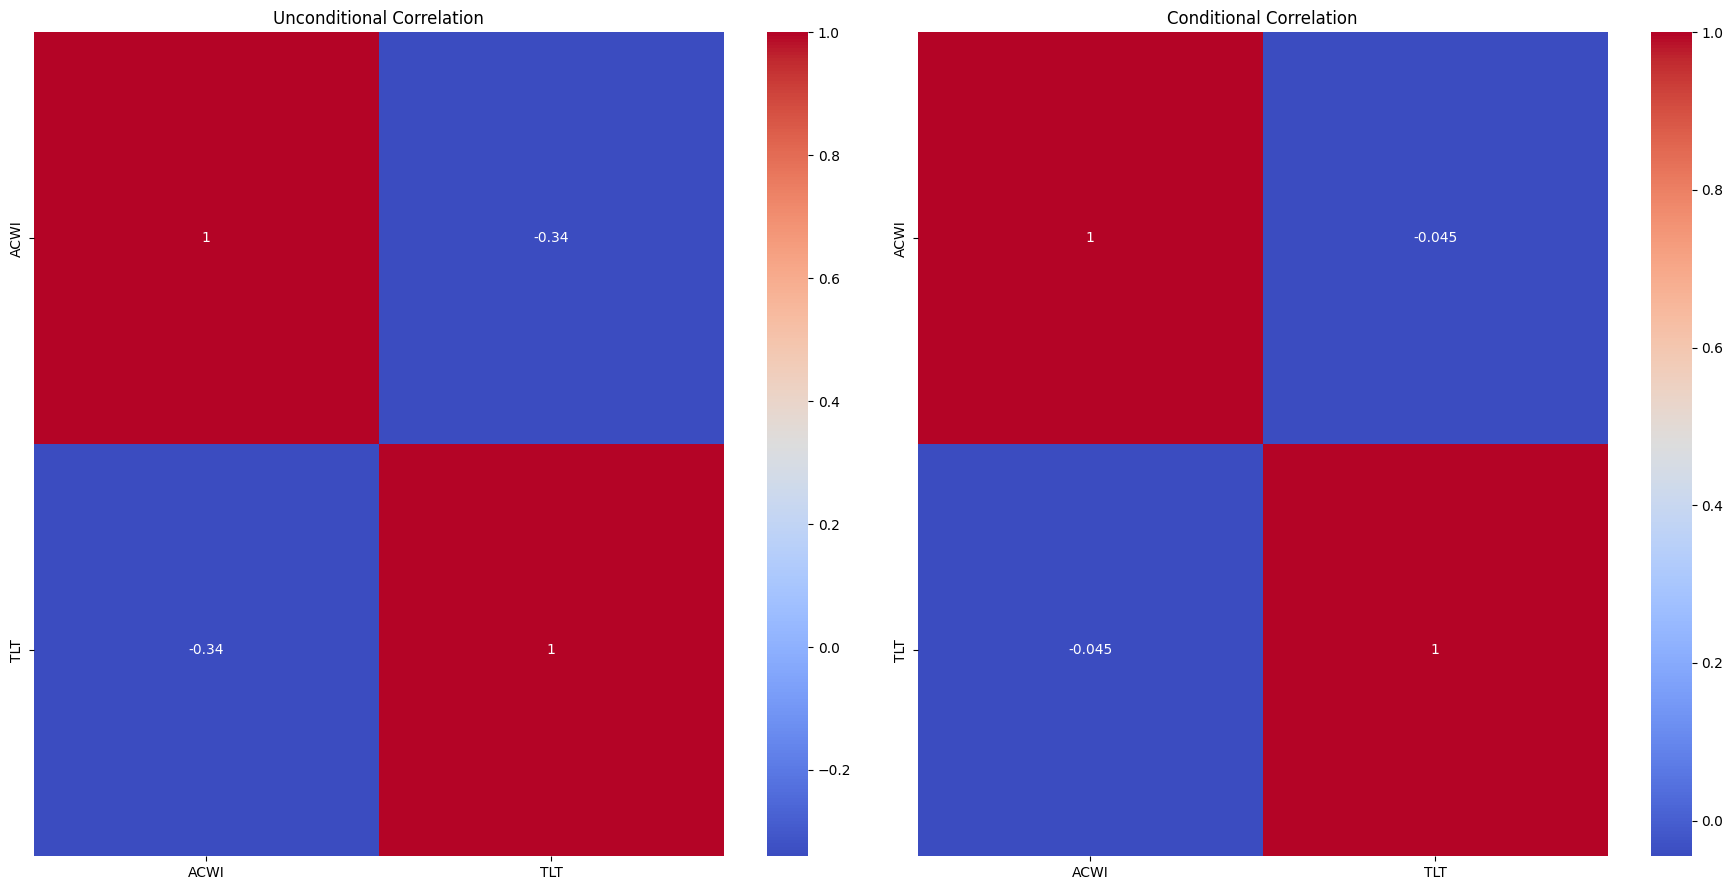

In [3]:
df = pd.read_csv('C2A.csv')

data, labels = df_to_array(df)
print(data)
N, T= data.shape
# Estimate Univariate Parameters
univ_params = estimate_univariate_parameters(data, labels)
fitted = fit(data)
print(fitted)
result_matrix = form_correlation_matrix(fitted.x)

plot_heatmaps(df, result_matrix, labels)

[[-0.01569131  0.02660959  0.01099555 ...  0.00028596  0.01710417
   0.00037464]
 [ 0.00349178  0.03455552  0.00065857 ...  0.00090542  0.02048426
   0.00068943]]
Time Series: ACWI, 
    Estimated parameters: 
 	 omega = 0.0005892030658852357, 
 	 alpha = 0.05892156572826546, 
 	 beta = 0.20622547993930598
Time Series: SPY, 
    Estimated parameters: 
 	 omega = 0.0264639398341318, 
 	 alpha = 0.19957971038918965, 
 	 beta = 0.6999413311616557
[0.42978298173891516]
-160749.98582013522
-160749.9877524441
-8034076.537025707
-8034068.50682441
-128433.34978414304
-128433.34958153137
-127833.95853536828
-127833.95847537529
-127775.77304555572
-127775.77304504788
-127775.7688753995
-127775.76887539949
-127775.76887539947
-127775.7688753995
-127775.76887539946
-127775.7688753995
-127775.76887539946
-127775.76887539949
-127775.76887539947
-127775.76887539947
  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 127775.76887539947
        x: [ 1.305

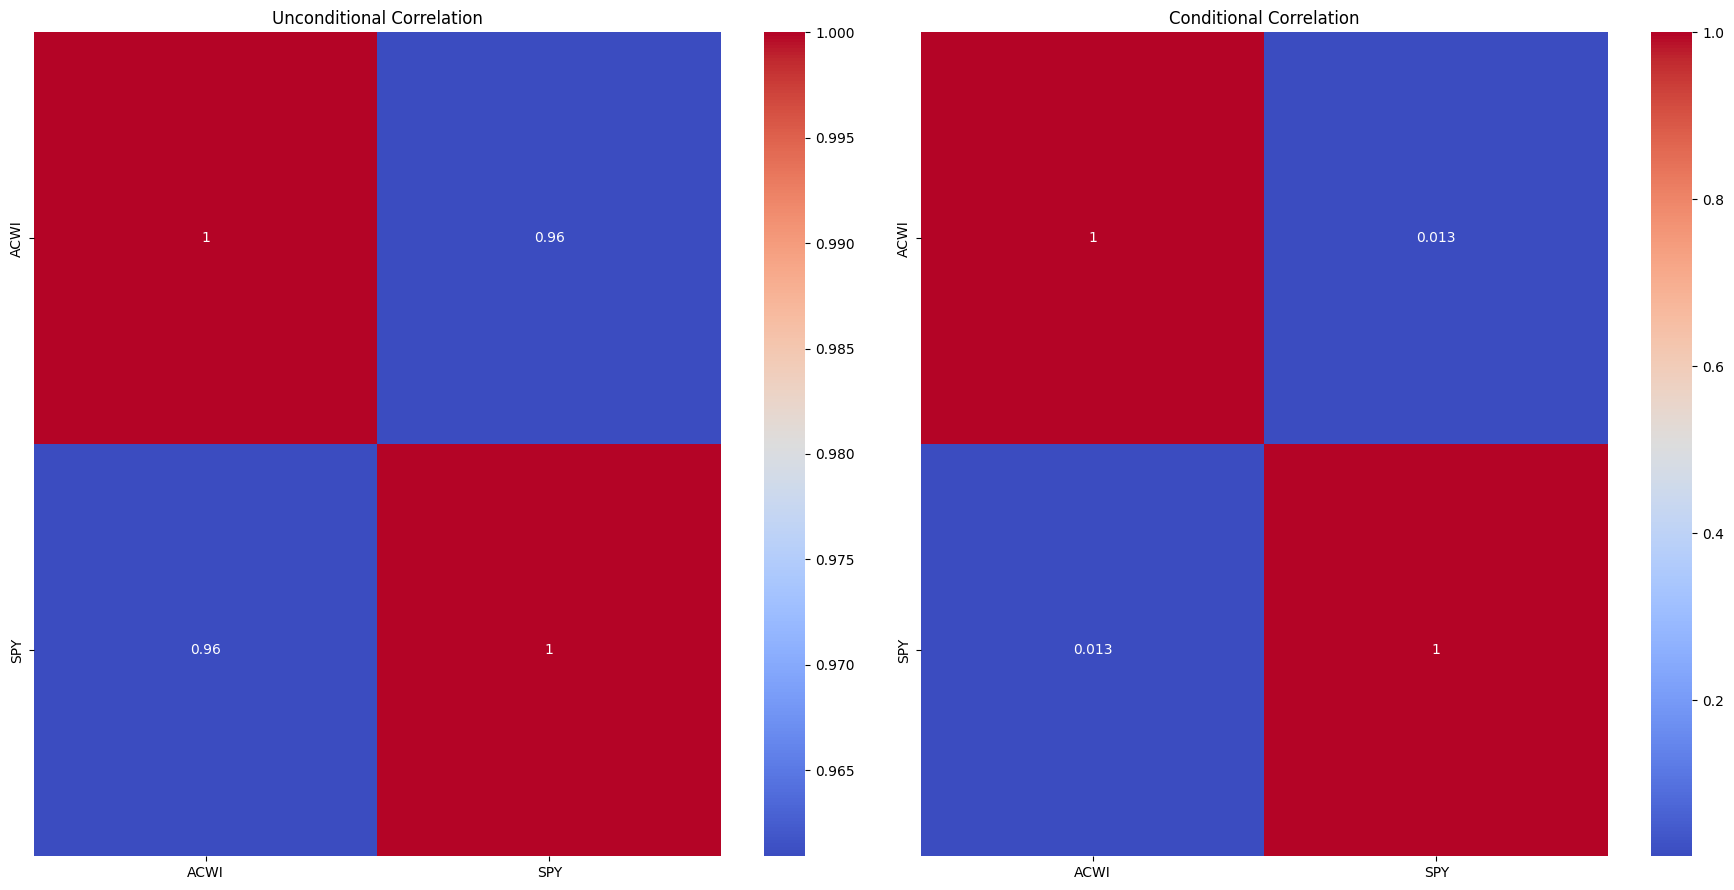

In [4]:
df = pd.read_csv('C2B.csv')

data, labels = df_to_array(df)
print(data)
N, T= data.shape
# Estimate Univariate Parameters
univ_params = estimate_univariate_parameters(data, labels)
fitted = fit(data)
print(fitted)
result_matrix = form_correlation_matrix(fitted.x)

plot_heatmaps(df, result_matrix, labels)

[[-0.01569131  0.02660959  0.01099555 ...  0.00028596  0.01710417
   0.00037464]
 [ 0.00349178  0.03455552  0.00065857 ...  0.00090542  0.02048426
   0.00068943]
 [ 0.00355199 -0.02065187  0.00212695 ... -0.00713435  0.00486984
   0.01329784]]
Time Series: ACWI, 
    Estimated parameters: 
 	 omega = 0.0034510816589451683, 
 	 alpha = 0.003573220161420507, 
 	 beta = 0.01262587296129308
Time Series: SPY, 
    Estimated parameters: 
 	 omega = 0.028465617576531658, 
 	 alpha = 0.0, 
 	 beta = 0.0
Time Series: TLT, 
    Estimated parameters: 
 	 omega = 0.0015744189165169673, 
 	 alpha = 0.0, 
 	 beta = 0.0
[0.09391175369916038, -0.05042142891472501, -0.4300388235483974]
-69908.60687760916
-69908.6069998981
-69908.60720068768
-69908.60591218135
-6351645.760216528
-6351645.611620279
-6351642.924272542
-6351642.343611502
-61874.59433071173
-61874.594075220346
-61874.59375359844
-61874.594281619386
-54260.13907115896
-54260.13895347118
-54260.139140751126
-54260.13922401703
-52717.489216735

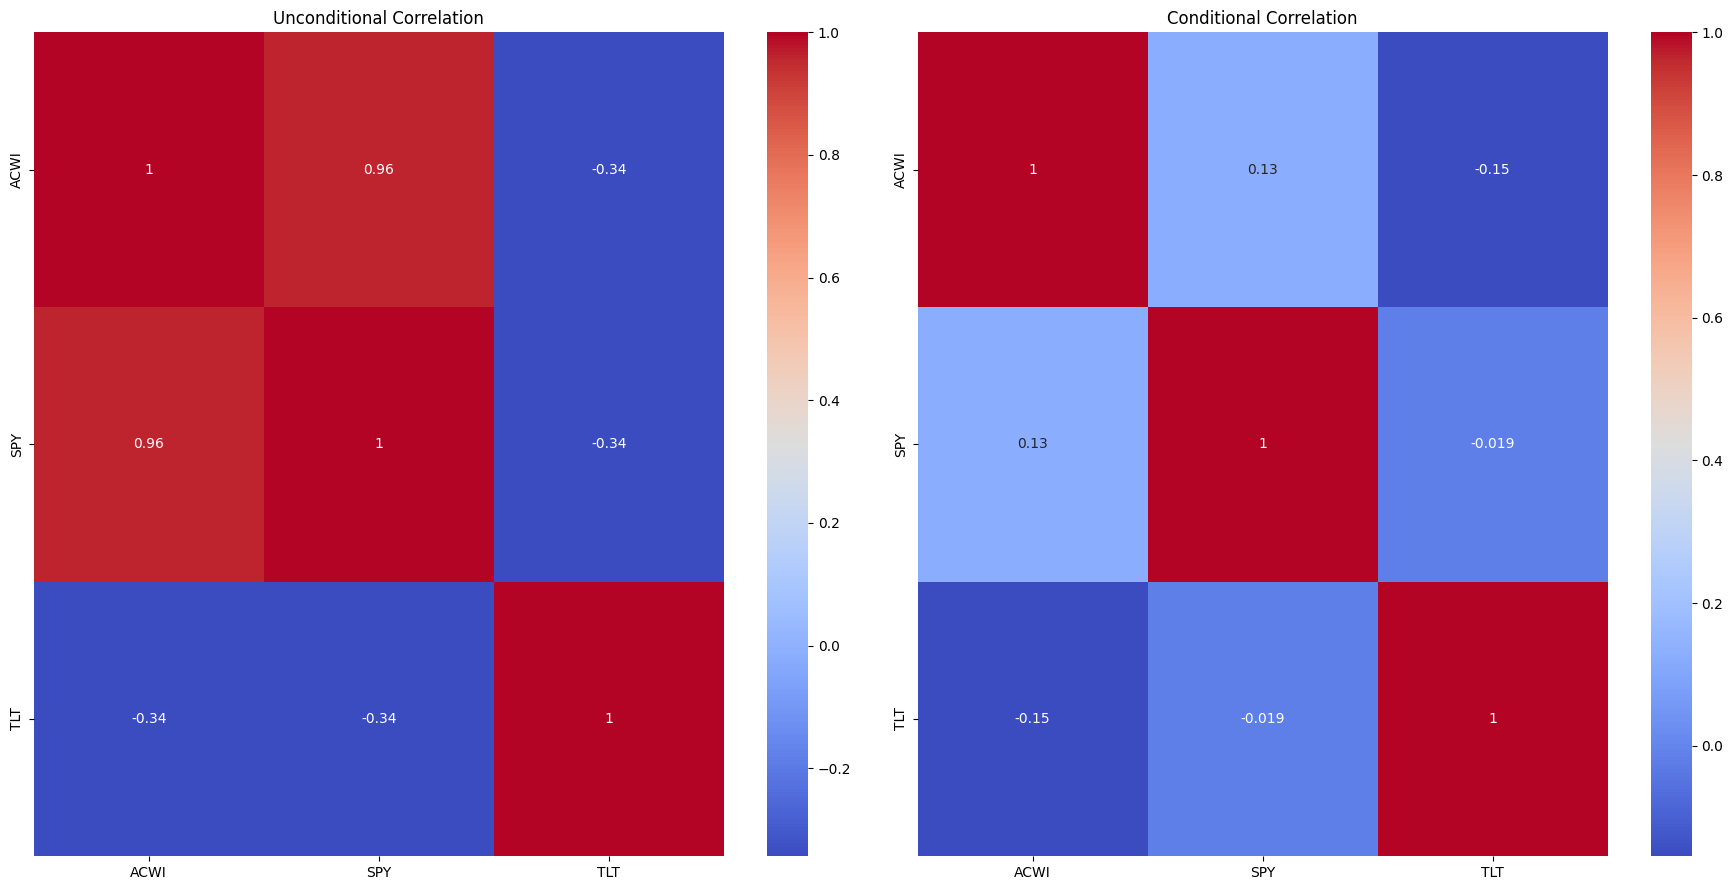

In [8]:
df = pd.read_csv('C3.csv')

data, labels = df_to_array(df)
print(data)
N, T= data.shape
# Estimate Univariate Parameters
univ_params = estimate_univariate_parameters(data, labels)
fitted = fit(data)
print(fitted)
result_matrix = form_correlation_matrix(fitted.x)

plot_heatmaps(df, result_matrix, labels)

[[-0.01569131  0.02660959  0.01099555 ...  0.00028596  0.01710417
   0.00037464]
 [ 0.00349178  0.03455552  0.00065857 ...  0.00090542  0.02048426
   0.00068943]
 [ 0.00355199 -0.02065187  0.00212695 ... -0.00713435  0.00486984
   0.01329784]
 [ 0.00586632  0.02903316 -0.00020668 ...  0.00097113  0.00869782
   0.00024058]]
Time Series: ACWI, 
    Estimated parameters: 
 	 omega = 0.00444307604474696, 
 	 alpha = 0.0, 
 	 beta = 0.0
Time Series: SPY, 
    Estimated parameters: 
 	 omega = 0.028656047059962365, 
 	 alpha = 0.0, 
 	 beta = 0.0
Time Series: TLT, 
    Estimated parameters: 
 	 omega = 0.0012910329760983834, 
 	 alpha = 0.0, 
 	 beta = 0.0
Time Series: VWO, 
    Estimated parameters: 
 	 omega = 0.0013173928321367052, 
 	 alpha = 0.0, 
 	 beta = 1.0
[0.052505225145929035, 0.277867614811125, -0.24479786191882558, 0.452359950738347, -0.4466261894737382, -0.10956857489882377]
-161454.7559406228
-161454.75459947798
-161454.75820952666
-161454.75527593796
-161454.7588997865
-1614

/tmp/ipykernel_654025/2378032172.py:203: RuntimeWarning: invalid value encountered in log
  term_3 = np.log(det_R)


nan
nan
nan
nan
nan
  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: nan
        x: [ 1.472e-01 -1.067e-01  2.024e-01 -9.900e-03  7.832e-01
             6.395e-03]
      nit: 18
      jac: [-1.252e+04  2.283e+03  1.559e+04  1.086e+03 -1.565e+03
             5.813e+02]
     nfev: 189
     njev: 27
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
4


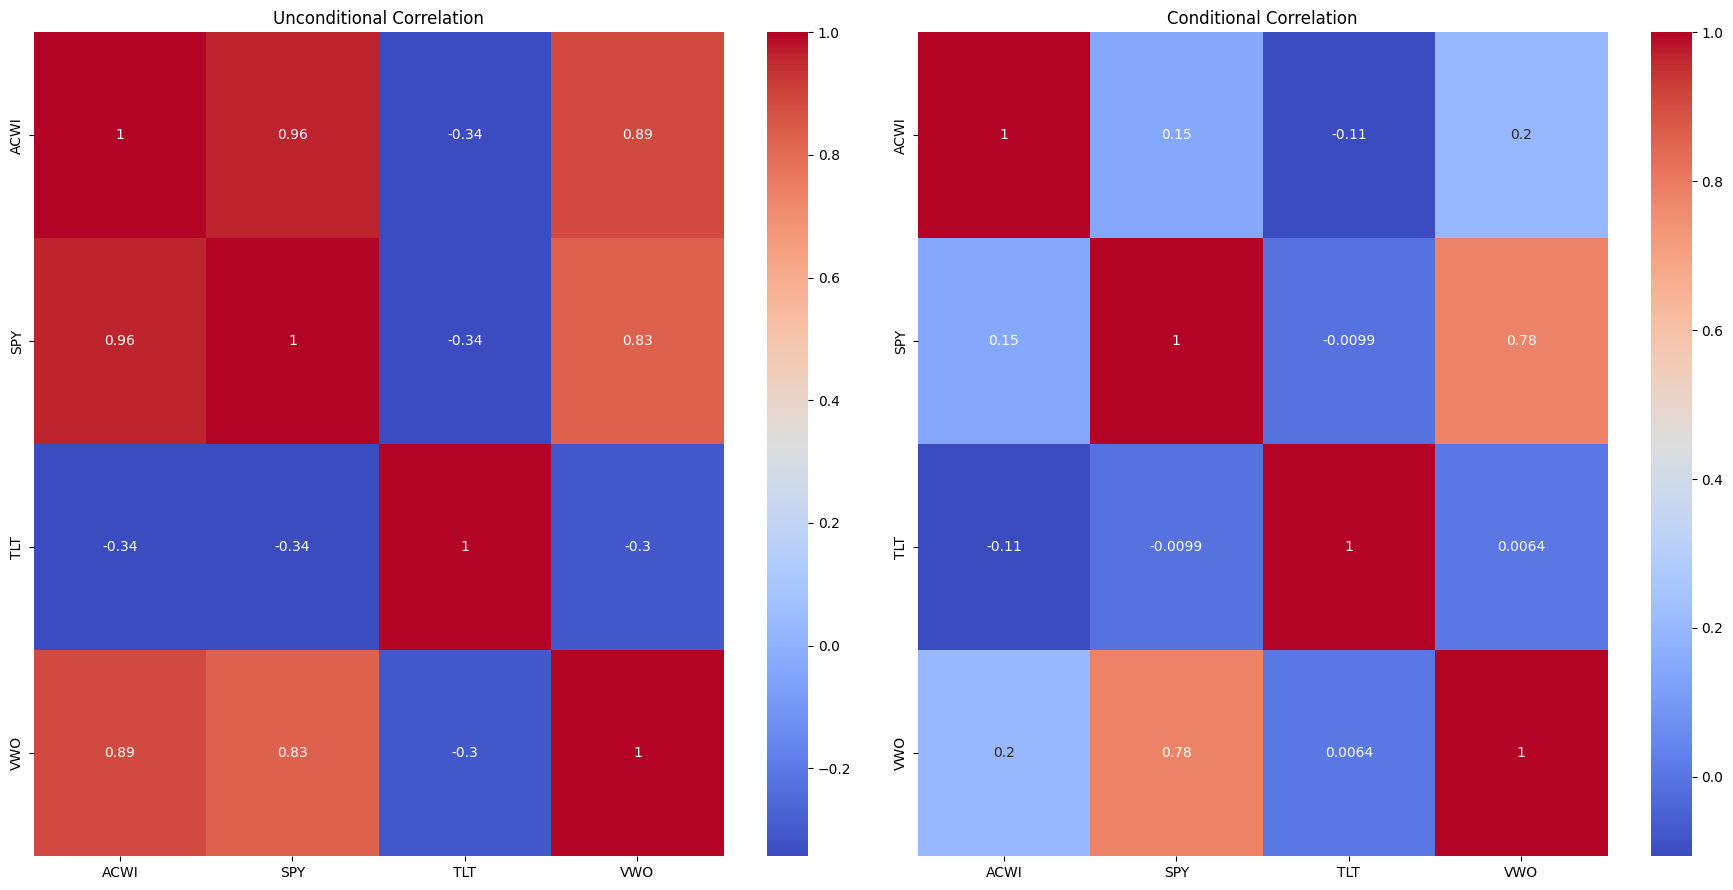

In [9]:
df = pd.read_csv('C4.csv')

data, labels = df_to_array(df)
print(data)
N, T= data.shape
# Estimate Univariate Parameters
univ_params = estimate_univariate_parameters(data, labels)
fitted = fit(data)
print(fitted)
result_matrix = form_correlation_matrix(fitted.x)

plot_heatmaps(df, result_matrix, labels)

# Setup of functions for estimation


# The Likelihood Functions


# Minimize

In [10]:

fitted

[0.0024200948483696916, 0.3077191795238656, -0.08101486874128327, -0.01390825385788419, -0.30945934455272317, 0.3534973501224088]


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -2679.5858588767214
        x: [ 1.524e-01 -1.636e-03  1.238e-01 -9.198e-02  4.664e-01
            -5.327e-02]
      nit: 11
      jac: [ 3.001e-03 -6.503e-03 -9.186e-03  9.368e-03  5.275e-03
             1.819e-03]
     nfev: 91
     njev: 13
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [11]:

result_matrix

array([[ 1.        ,  0.15236583, -0.00163577,  0.12375298],
       [ 0.15236583,  1.        , -0.09197732,  0.46640269],
       [-0.00163577, -0.09197732,  1.        , -0.05327369],
       [ 0.12375298,  0.46640269, -0.05327369,  1.        ]])

4


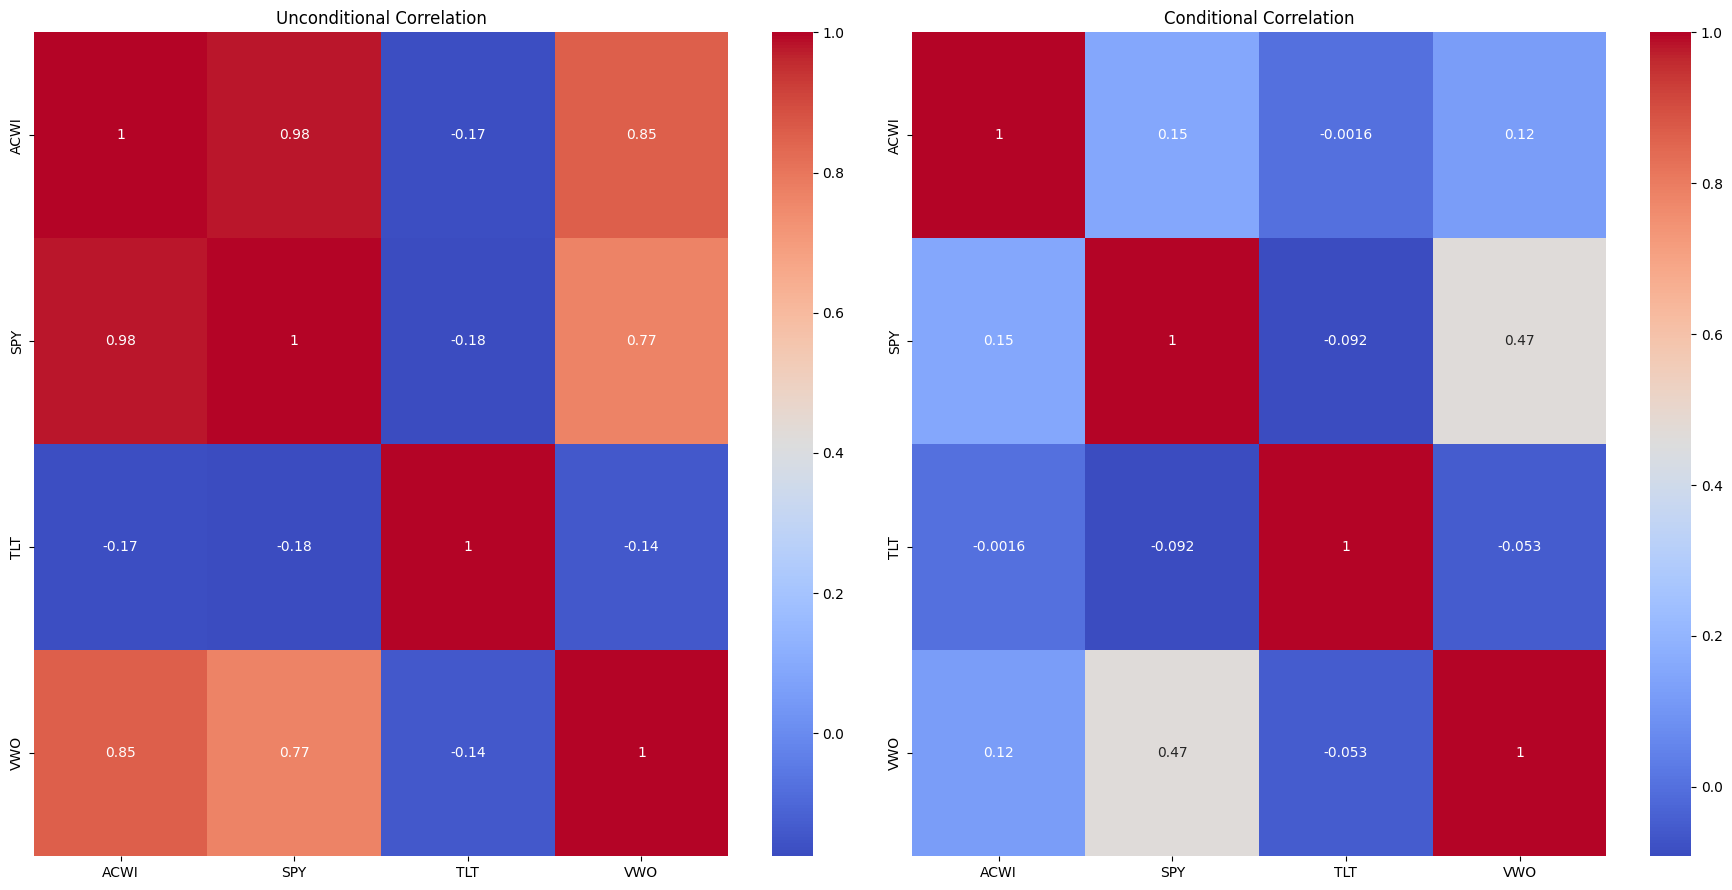